Use CWRU dataset to train an unsupervised classification model. 

Load labelled data and describe. 

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

random.seed(42)

DATA_FILE = 'ML_train.csv'
TARGET = 'Fault type'
ENCODED_TARGET = 'Encoded fault type'

train_df = pd.read_csv(DATA_FILE)
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4659 entries, 0 to 4658
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Kurtosis             4659 non-null   float64
 1   Crest factor         4659 non-null   float64
 2   Skewness             4659 non-null   float64
 3   Standard deviation   4659 non-null   float64
 4   RMS                  4659 non-null   float64
 5   Peak-to-peak factor  4659 non-null   float64
 6   rms_mid_frequency    4659 non-null   float64
 7   peak_frequency       4659 non-null   float64
 8   rms_overall          4659 non-null   float64
 9   rms_low_frequency    4659 non-null   float64
 10  peak_amplitude       4659 non-null   float64
 11  Encoded fault type   4659 non-null   int64  
 12  Fault type           4659 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 473.3+ KB
None


There are no missing values in data. Normalize data. 

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_df.drop([TARGET, ENCODED_TARGET], axis=1))
scaled_df = pd.DataFrame(scaled_data, columns=train_df.drop([TARGET, ENCODED_TARGET], axis=1).columns)
print(scaled_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4659 entries, 0 to 4658
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Kurtosis             4659 non-null   float64
 1   Crest factor         4659 non-null   float64
 2   Skewness             4659 non-null   float64
 3   Standard deviation   4659 non-null   float64
 4   RMS                  4659 non-null   float64
 5   Peak-to-peak factor  4659 non-null   float64
 6   rms_mid_frequency    4659 non-null   float64
 7   peak_frequency       4659 non-null   float64
 8   rms_overall          4659 non-null   float64
 9   rms_low_frequency    4659 non-null   float64
 10  peak_amplitude       4659 non-null   float64
dtypes: float64(11)
memory usage: 400.5 KB
None


Split into features and target. Then split into training and testing data.

In [19]:
from sklearn.model_selection import train_test_split

x = scaled_df
y = train_df[ENCODED_TARGET]
y = y.to_frame(name=ENCODED_TARGET)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

Explore clustering.

Inertia measures how well a dataset was clustered by the k-means algorithm. To find the optimal number of clusters (K) for the dataset, the 'elbow method' can be used to find the point where the decrease in inertia begins to slow (https://www.ibm.com/topics/k-means-clustering). This can also be done with the KElbowVisualizer. 

In [ ]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
import seaborn as sns

clusters = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(x)
    clusters.append(kmeans.inertia_)

# Plot Inertia vs. Clusters, i.e. the Elbow method graph
plt.figure(figsize=(6, 5))
sns.lineplot(x=list(range(1, 11)), y=clusters)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Elbow method graph')
plt.show()
plt.close()

# Use the KElbowVisualizer to visualize Inertia vs. Clusters
kl = KneeLocator(range(1, 11), clusters, curve='convex', direction='decreasing')
kl.elbow

plt.figure(figsize=(6, 5))
plt.plot(range(1, 11), clusters, marker='^', c='b', ms=9, mfc='r')
plt.title('Elbow method graph using kneed library')
plt.xticks(range(1, 11))
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.axvline(x=kl.elbow, color='gray', ls='--')
plt.plot()


The elbow method shows data clusters optimally into either 2 or 3 based on the elbow method. Visualize both options. 

In [ ]:
optimal_clusters = [2, 3]

for n in optimal_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42).fit(x)
    x['Labels'] = kmeans.labels_
    sns.pairplot(x, hue='Labels')
    plt.show()

Compare resulting clusters with actual classes distribution. 

In [ ]:
# Create a binary classified dataset from the original dataset, i.e. replace all fault types with 'Anomaly' class
labelled_df = train_df.drop([ENCODED_TARGET], axis=1)
labelled_df[TARGET] = labelled_df[TARGET].mask(labelled_df[TARGET] != 'Time_Normal', 'Anomaly')

sns.pairplot(labelled_df, hue=TARGET)
plt.show()

Judging from the actual classes distribution, K-Means is not the best algorithm for this. Let's try Gaussian Mixture Models or Spectral Clustering. 

      Kurtosis  Crest factor  Skewness  Standard deviation       RMS  \
0    -0.377109     -0.311024  0.093338           -0.820165 -0.807200   
1    -0.439419     -0.406291 -0.600167           -0.761247 -0.751005   
2    -0.555843     -1.116220 -0.039573           -0.868287 -0.858493   
3    -0.473581     -0.925397 -1.517481           -0.798572 -0.795437   
4    -0.354349     -0.541518 -0.905928           -0.756615 -0.751171   
...        ...           ...       ...                 ...       ...   
4654 -0.610744      0.008688  0.646282           -0.953507 -0.950487   
4655 -0.452644      0.083914  0.792413           -0.980154 -0.971949   
4656 -0.539377     -0.479323  0.772494           -1.086361 -1.066327   
4657 -0.395024     -0.387563  1.072255           -1.040275 -1.021575   
4658 -0.534620     -0.611276  0.798596           -1.047849 -1.026698   

      Peak-to-peak factor  rms_mid_frequency  peak_frequency  rms_overall  \
0               -0.741835          -0.532473       -1.0999

<Figure size 600x500 with 0 Axes>

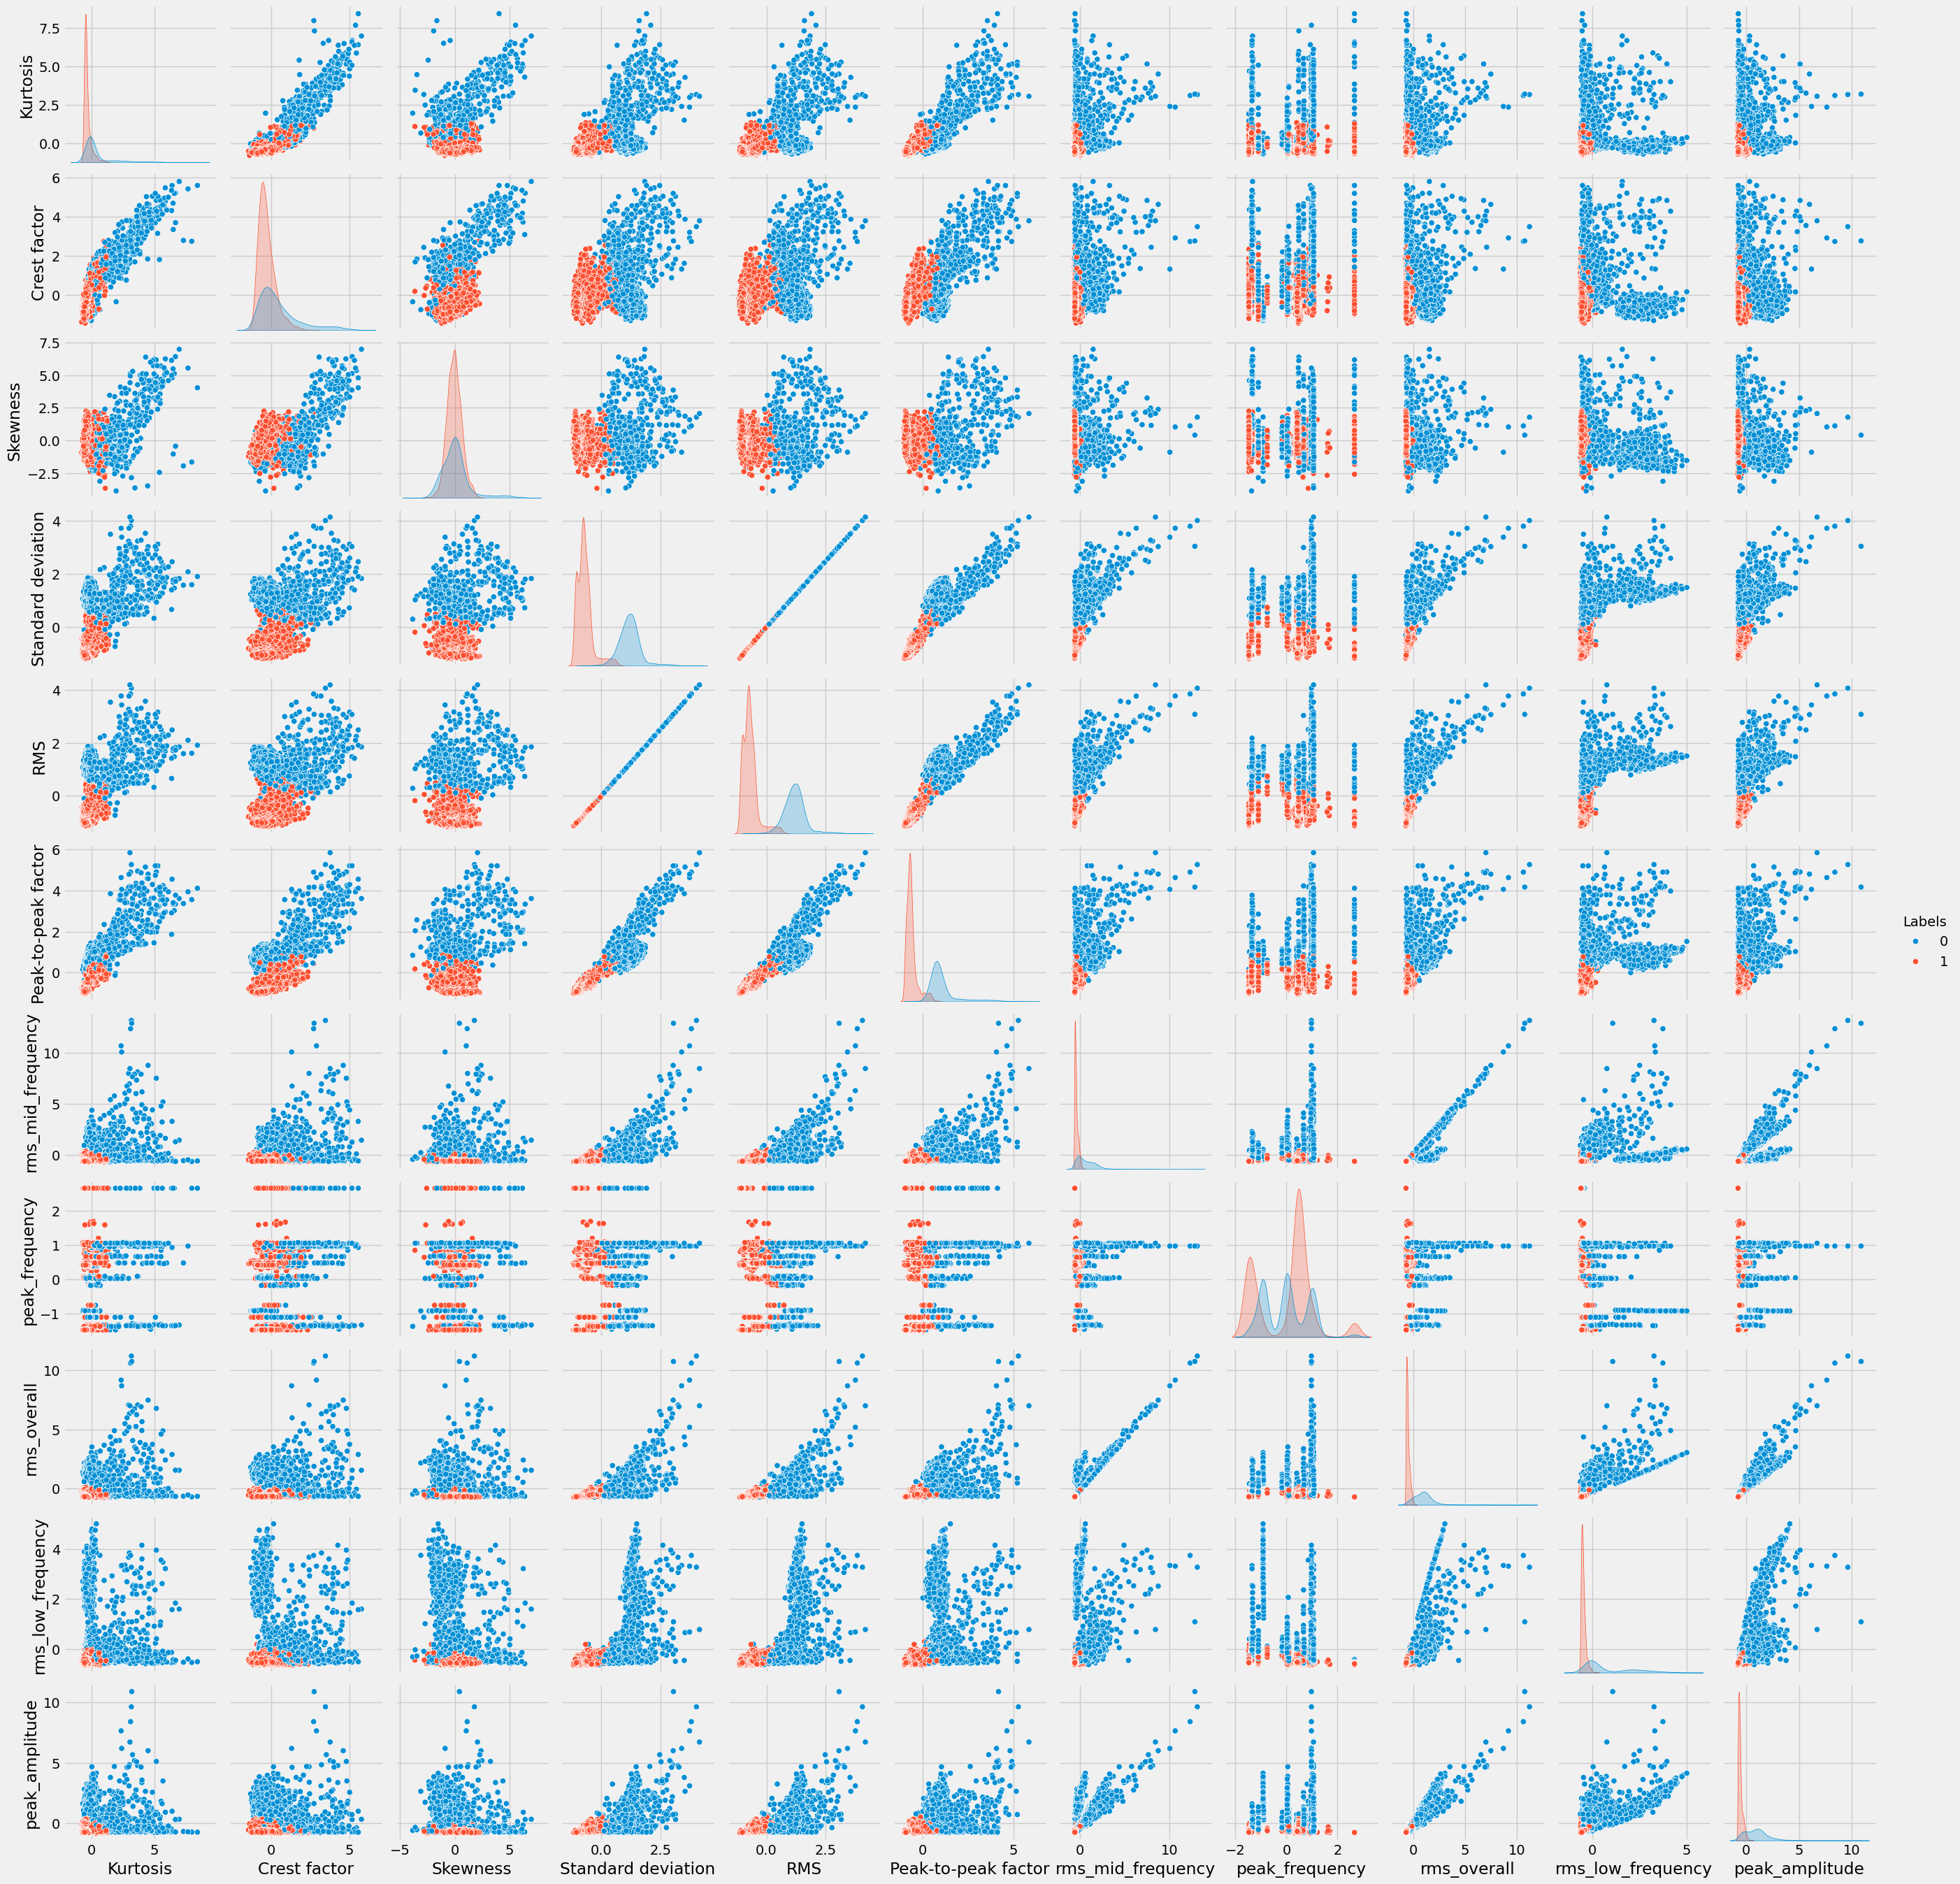

In [34]:
from sklearn.mixture import GaussianMixture

x = x.drop('Labels', axis=1)  # drop previous clustering labels 

gmm = GaussianMixture(n_components=2, random_state=42).fit(x).fit(x)
labels = gmm.predict(x)

plt.figure(figsize=(6, 5))
x['Labels'] = labels
sns.pairplot(scaled_df, hue='Labels')
plt.show()
plt.close()

<Figure size 600x500 with 0 Axes>

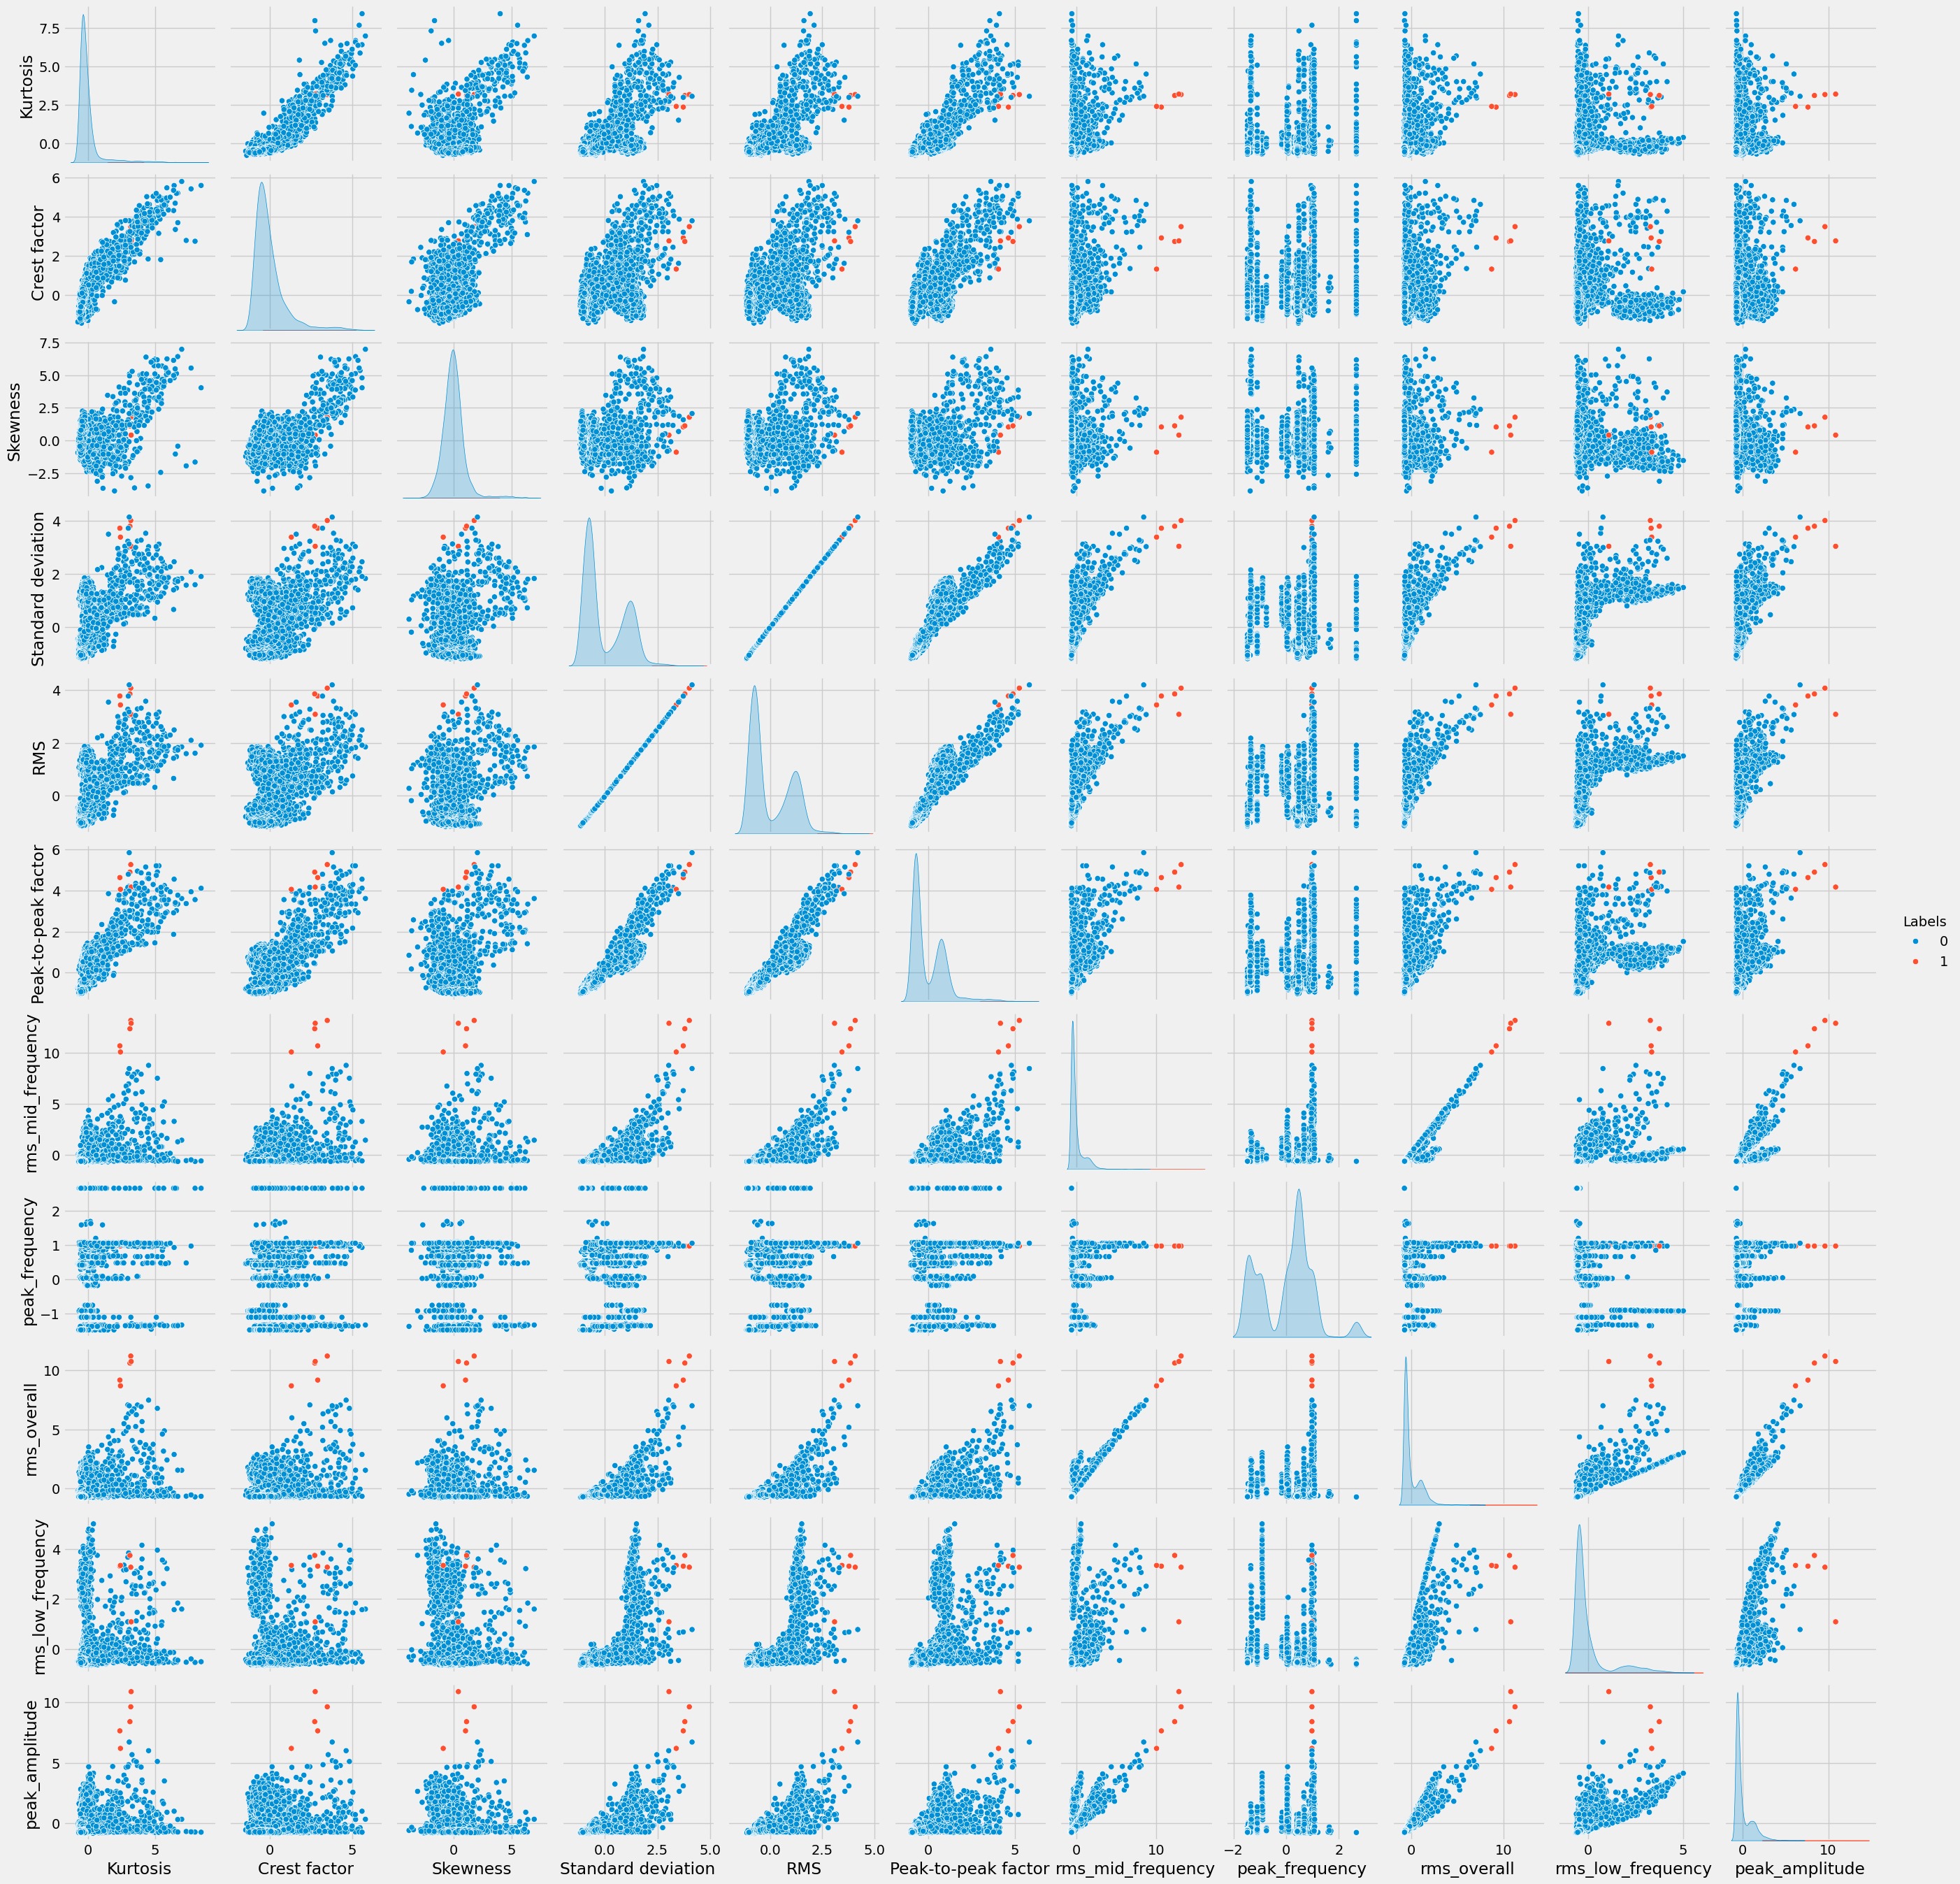

In [38]:
from sklearn.cluster import SpectralClustering

x = x.drop('Labels', axis=1)  # drop previous clustering labels

sc_labels = SpectralClustering(n_clusters=2, random_state=42).fit_predict(scaled_df)
x['Labels'] = sc_labels

plt.figure(figsize=(6, 5))
sns.pairplot(x, hue='Labels')
plt.show()
plt.close()
